In [24]:
import pickle
import subprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rc('pdf', fonttype=42)  # Enable pdf compatible fonts 

import scipy.stats

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import Bio.SeqIO

In [25]:
# Sample information
ortholog = 'Cas13bt-2'
samples = ['Bt2_BR1_S4_R1_001spacers.p', 'Bt2_BR2_S5_R1_001spacers.p', 'Bt2_BR3_S6_R1_001spacers.p', 'Bt2ctrl_BR1_S1_R1_001spacers.p', 'Bt2ctrl_BR2_S2_R1_001spacers.p', 'Bt2ctrl_BR3_S3_R1_001spacers.p', 'Bt2_input_S7_R1_001spacers.p']
samples_to_names = {samples[0] : 'Cas13bt2 Experiment Rep 1',
                   samples[1] : 'Cas13bt2 Experiment Rep 2',
                   samples[2] : 'Cas13bt2 Experiment Rep 3',
                   samples[3] : 'Cas13bt2 Control Rep 1',
                   samples[4] : 'Cas13bt2 Control Rep 2',
                   samples[5] : 'Cas13bt2 Control Rep 3',
                   samples[6] : 'Cas13bt2 Input Library',
                      }
# Map sample ids tosample names and filepaths
sample_pair = (samples[0], samples[2])
pair_names = [samples_to_names[sample_pair[0]], samples_to_names[sample_pair[1]]]

# Load non-targeting spacers list 
nt_spacers = []
with open('nt_spacers.csv', 'r') as f:
    for line in f:
        nt_spacers.append(line.strip())

In [26]:
# Obtain the experiment condition sample information
e_N_avg = {}
e_Ns = []
es = []
for e_name in samples[0:3]:
    e = pickle.load(open(e_name, 'rb'), encoding='latin1')
    # Get sum of all read counts
    e_sum = sum([v for v in e.values()])
    # Normalize individual spacer count by sum of all read counts in sample
    e_N = {u : float(v)/e_sum for u,v in e.items()}
    e_Ns.append(e_N)
    es.append(e)
for u in e_Ns[0]:
    e_N_avg[u] = ((e_Ns[0][u], e_Ns[1][u], e_Ns[2][u]), (es[0][u], es[1][u], es[2][u]))

In [27]:
# Obtain the control condition sample information
c_N_avg = {}
c_Ns = []
cs = []
for c_name in samples[3:6]:
    c = pickle.load(open(c_name, 'rb'), encoding='latin1')
    # Get sum of all read counts    
    c_sum = sum([v for v in c.values()])
    # Normalize individual spacer count by sum of all read counts in sample    
    c_N = {u : float(v)/c_sum for u,v in c.items()}
    c_Ns.append(c_N)
    cs.append(c)
for u in c_Ns[0]:
    c_N_avg[u] = ((c_Ns[0][u], c_Ns[1][u], c_Ns[2][u]), (cs[0][u], cs[1][u], cs[2][u]))

In [28]:
# Compute the ratios between the average experimental condition abundance and average control condition abundance 
ratios = {}
for u in c_N_avg:
    # Keep track of total read counts across replicates
    c_total_count = np.sum(c_N_avg[u][1])
    e_total_count = np.sum(e_N_avg[u][1])
    c_abundance = np.average(c_N_avg[u][0])
    e_abundance = np.average(e_N_avg[u][0])
    # Use 1e-9 to avoid divsion by near zero
    ratios[u] = (c_total_count, e_total_count, c_abundance, e_abundance, e_abundance / (c_abundance+1e-9))

In [29]:
eps = 1e-12  # Additive constant to avoid division by small numbers
min_read_count = 100  # Minimum read count for  analysis 
sigma = 5  # Number of standard deviations away from mean to establish significance

# Obtain targeting and non-targeting experiment (Y) vs control (X) average abundances. 
X,Y = zip(*[(v[2]+eps, v[3]+eps) for u,v in ratios.items() if v[0] >= min_read_count and not u in nt_spacers])
X_nt, Y_nt = zip(*[(v[2]+eps, v[3]+eps) for u,v in ratios.items() if v[0] >= min_read_count and u in nt_spacers])

# Obtain mean, medan and all log depletion ratios of non-targeting spacers
mean = np.mean(np.array(np.log10(Y_nt)) - np.log10(np.array(X_nt)))
median = np.median(np.array(np.log10(Y_nt)) - np.log10(np.array(X_nt)))

# Get the spacers depletion ratios of the non-targets
dep = np.log10(np.array(Y_nt)) - np.log10(np.array(X_nt))

# Perform fit on two component Gaussian mixture model
x_d = np.linspace(-4,2, 200)

m = GaussianMixture(n_components=2)
m.fit(dep[:, None])

m_m = m.means_[0]
m_std = np.sqrt(m.covariances_[0])
logprob1 = scipy.stats.norm(m_m,m_std).logpdf(x_d)[0,:]

m_m = m.means_[1]
m_std = np.sqrt(m.covariances_[1])
logprob2 = scipy.stats.norm(m_m,m_std).logpdf(x_d)[0,:]

hi_idx = np.argsort(m.means_.flatten())[-1]
print(m.means_)
high_mean = m.means_[hi_idx]
high_std = np.sqrt(m.covariances_[hi_idx])

# Renormalize targeting and  non-targeting conditions by the control median (which is in log10 space)
# Normalization parameter for all experimental conditions (to keep depletions of non-target with no offtarget 
# centered at 1)
median = high_mean

Y = np.array(Y) / np.power(10, median)
Y_nt = np.array(Y_nt) / np.power(10, median)

# Redo the GMM fit using the renormalized data
dep = np.log10(np.array(Y_nt)) - np.log10(np.array(X_nt))

x_d = np.linspace(-4,2, 200)

m = GaussianMixture(n_components=2)
m.fit(dep[:, None])

m_m = m.means_[0]
m_std = np.sqrt(m.covariances_[0])
logprob1 = scipy.stats.norm(m_m,m_std).logpdf(x_d)[0,:]

m_m = m.means_[1]
m_std = np.sqrt(m.covariances_[1])
logprob2 = scipy.stats.norm(m_m,m_std).logpdf(x_d)[0,:]

hi_idx = np.argsort(m.means_.flatten())[-1]
print(m.means_)
high_mean = m.means_[hi_idx]
high_std = np.sqrt(m.covariances_[hi_idx])

depletion_thresh = float(np.power(10, high_mean - sigma*high_std))
print(depletion_thresh)

[[-0.00684407]
 [-0.02439363]]
[[ 2.86452797e-05]
 [-1.74719429e-02]]
0.6695222154426117


In [56]:
import json
"""
with open('./randoms.json', 'w') as f:
    data =  {'median' : float(median), 'high_mean' : float(high_mean), 
               'high_std' : float(high_std), 'depletion_thresh' : float(depletion_thresh)}
    json.dump(data, f, sort_keys=True, indent=4)
"""
with open('./randoms.json', 'r') as f:    
    d = json.load(f)
    print(d)

{'depletion_thresh': 0.6695222154426117, 'high_mean': 2.8645279745224694e-05, 'high_std': 0.034852730670116024, 'median': -0.006844065311538109}


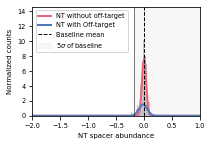

In [30]:
plt.figure(figsize=(3,2))
plt.axvspan(np.log10(depletion_thresh),high_mean+10,color='k',alpha=0.03)
plt.hist(dep,density=True, bins=100, color=[193/255,195/255,200/255],label='_nolegend_')
plt.plot(x_d, m.weights_[0]*np.exp(logprob1), color=[241/255,97/255,121/255], lw=2)
plt.plot(x_d, m.weights_[1]*np.exp(logprob2), color=[74/255,121/255,188/255], lw=2)
plt.axvline(np.log10(depletion_thresh), c='k',label='_nolegend_', lw=0.5)
plt.axvline(high_mean, c='k', ls='--', lw=1)
plt.xlim([-2,1])
plt.ylabel('Normalized counts')
plt.xlabel('NT spacer abundance')
plt.legend(['NT without off-target','NT with Off-target','Baseline mean',r'5$\sigma$ of baseline'], prop={'size': 6.5})
ax = plt.gca()
for item in ([] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(6.5)
for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(7)
plt.savefig('./generated_data_and_data/'+ortholog+' nt GMM.pdf')

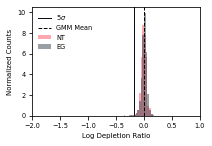

In [52]:
bins = np.linspace(-2,1,100)
plt.figure(figsize=(3,2))

u = np.histogram(np.log10(np.array(Y_nt) / np.array(X_nt)), bins=bins, density=True)
plt.fill_between(u[1][1:],u[0], step="pre", color=[[255/255, 81/255, 101/255]], lw=0, alpha=0.5)

u = np.histogram(np.log10(np.array(Y) / np.array(X)), bins=bins, density=True)
plt.fill_between(u[1][1:],u[0], step="pre", color=[[0.2, 0.25, 0.3]], lw=0, alpha=0.5)

plt.xlim([-2, 1])
plt.axvline(np.log10(depletion_thresh), linestyle='-', color=[0.05, 0.05, 0.1],lw=1)
plt.axvline(high_mean, c='k', ls='--', lw=1)
plt.xlabel('Log Depletion Ratio')
plt.ylabel('Normalized Counts')
plt.legend(['5$\sigma$','GMM Mean','NT', 'EG'], loc='upper left', frameon=False, prop={'size' : 6.5})
plt.ylim([0,10.5])
ax = plt.gca()
for item in ([] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(6.5)
for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(7)
    
plt.savefig('./generated_data_and_data/'+ortholog + ' Depletion Ratios.pdf')
plt.show()

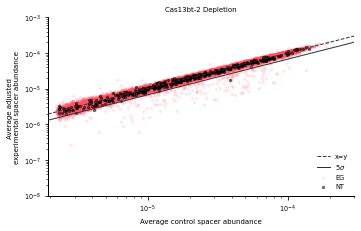

In [57]:
# Plot experimental vs control abundance 
fig = plt.figure(figsize=(5,3.2))
ax = plt.gca()
x_l, x_r = min([min(X), min(X_nt)])/10*9, 3e-4
X_line = np.linspace(x_l, x_r, 1000)
Y_line = depletion_thresh*X_line
Y_middle_line = X_line

plt.plot(X_line, Y_middle_line, '--', c=[0.2, 0.2, 0.2], linewidth=1, zorder=3)
plt.plot(X_line, Y_line, '-', c=[0.2, 0.2, 0.2], linewidth=1, zorder=3)
plt.scatter(X, Y, color=[[255/255, 81/255, 101/255]], marker='o', s=5, alpha=0.1, rasterized=True,lw=None)
plt.scatter(X_nt, Y_nt, color='k', marker='o', s=5, alpha=0.5, rasterized=True, lw=None)

plt.xlim([x_l, x_r])
plt.ylim([1e-8, 1e-3])
ax.set_yscale('log')
ax.set_xscale('log')
plt.title(ortholog + ' Depletion')

plt.xlabel('Average control spacer abundance')
plt.ylabel('Average adjusted \nexperimental spacer abundance')
plt.legend(['x=y','5$\sigma$', 'EG', 'NT'], loc='lower right', frameon=False,prop={'size' : 6.5})

[i.set_linewidth(1) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.gcf().subplots_adjust(bottom=0.15, left=0.2)

ax = plt.gca()
for item in ([] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(6.5)
for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(7)
plt.tight_layout()

plt.savefig('./generated_data_and_data/'+ortholog + ' Average Abundance Depletion.pdf', dpi=900)
plt.show()

In [33]:
combined_rep = [(u, (v[3]+eps) / (v[2]+eps) / np.power(10, median), v[0], v[1]) for u,v in ratios.items() if v[0] >= min_read_count and (v[3]+eps) / (v[2]+eps) / np.power(10, median) < depletion_thresh]
all_rep = [(u, (v[3]+eps) / (v[2]+eps) / np.power(10, median), v[0], v[1]) for u,v in ratios.items() if v[0] >= min_read_count]
non_depleted_rep = [(u, (v[3]+eps) / (v[2]+eps) / np.power(10, median), v[0], v[1]) for u,v in ratios.items() if v[0] >= min_read_count and (v[3]+eps) / (v[2]+eps) / np.power(10, median) >= depletion_thresh]
len(combined_rep), len(all_rep), len(non_depleted_rep)

(267, 31093, 30826)

In [34]:
# Index of the CDS sequences used in the experiment for targeting
cds_ids_in_exp = [
169,
46,
336,
1222,
793,
157,
156,
3994,
136,
1471,
1797,
2695,
2906,
2882,
3984,
3236,
2608,
2376,
3780,
179,
159,
28,
1018,
502,
3495,
2824,
448,
4592,
2903,
4399,
1056,
2685,
3751,
155,
1464,
1560,
2164,
1223,
1981,
2119,
447,
1484,
442,
3319,
2130,   
]

In [35]:
# Get the e coli transcripts (CDS)
spacer_len = 30

records = list(Bio.SeqIO.parse(open('e_coli.gbk'), 'genbank'))

genome_seq = records[0].seq
cds_orig = []
flank = 500
for i,feature in enumerate(records[0].features):
    if feature.type != 'CDS':
        continue
    loc = feature.location
    feature_seq = genome_seq[loc.start-flank:loc.end+flank]

    # Get the sense strand
    if feature.strand == -1:
        feature_seq = Bio.Seq.reverse_complement(feature_seq)
        
    cds_orig.append((feature.qualifiers['product'][0], feature_seq))
    
# Filter cds to only be those from 
cds = [cds_orig[i] for i in cds_ids_in_exp]

In [36]:
spacer_to_target_map = {}
for i,(u,v) in enumerate(ratios.items()):
    if v[0] < min_read_count:
        continue
    search = Bio.Seq.reverse_complement(u)
    s = ''
    coords = (None,None)
    for j,(name, seq) in enumerate(cds):
        idx = seq.find(search)
        if idx >= 6:
            s = seq[idx-6:idx+spacer_len+6]
            coords = (idx, (idx - flank) / (len(seq)-2*flank), 1)
            # Add to CDS
            break
            
    if s == '':
        continue
    if len(s) < spacer_len+12:
        continue
    spacer_to_target_map[u] = s

In [59]:
# Identfy weblogos (requires weblogo to be installed)

with open('./generated_data_and_data/for_logo_control.fa', 'w') as f:
    for i,(v) in enumerate(all_rep):
        if not v[0] in spacer_to_target_map:
            continue
        f.write('>'+str(i)+'\n')
        f.write(str(spacer_to_target_map[v[0]]).replace('T','U')+'\n')
        
subprocess.call(['weblogo',
                 '-s', 'small',
                 '-n', '42',
                 '-S', '0.05',  
                 '--ticmarks','0.05',                          
                 '-W', '4.8',
                 '-F','pdf',
                 '-D','fasta',
                 '--color', '#FAA51A', 'G', 'Guanidine',
                 '--color', '#0F8140', 'A', 'Adenosine',
                 '--color', '#ED2224', 'U', 'Uracil',
                 '--color','#3A53A4', 'C', 'Cytidine',
                 '-f', './generated_data_and_data/for_logo_control.fa',
                 '-o', './generated_data_and_data/'+ortholog+'_weblogo_control.pdf'])
        
with open('./generated_data_and_data/for_logo_non_depleted.fa', 'w') as f:
    for i,(v) in enumerate(non_depleted_rep):
        if not v[0] in spacer_to_target_map:
            continue
        f.write('>'+str(i)+'\n')
        f.write(str(spacer_to_target_map[v[0]]).replace('T','U')+'\n')
        
subprocess.call(['weblogo',
                 '-s', 'small',
                 '-n', '42',
                 '-S', '0.05',  
                 '--ticmarks','0.05',   
                 '-W', '4.8',                 
                 '-F','pdf',
                 '-D','fasta',
                 '--color', '#FAA51A', 'G', 'Guanidine',
                 '--color', '#0F8140', 'A', 'Adenosine',
                 '--color', '#ED2224', 'U', 'Uracil',
                 '--color','#3A53A4', 'C', 'Cytidine',
                 '-f', './generated_data_and_data/for_logo_non_depleted.fa',
                 '-o', './generated_data_and_data/'+ortholog+'_weblogo_non_depleted.pdf'])        
        
with open('./generated_data_and_data/for_logo_depleted.fa', 'w') as f:
    for i,(v) in enumerate(combined_rep):
        if not v[0] in spacer_to_target_map:
            continue
        f.write('>'+str(i)+'\n')
        f.write(str(spacer_to_target_map[v[0]]).replace('T','U')+'\n')
        
subprocess.call(['weblogo',
                 '-s', 'small',
                 '-n', '42',
                 '-S', '0.15',  
                 '--ticmarks','0.15',
                 '-W', '4.8',                 
                 '-F','pdf',
                 '-D','fasta',
                 '--color', '#FAA51A', 'G', 'Guanidine',
                 '--color', '#0F8140', 'A', 'Adenosine',
                 '--color', '#ED2224', 'U', 'Uracil',
                 '--color','#3A53A4', 'C', 'Cytidine',
                 '-f', './generated_data_and_data/for_logo_depleted.fa',
                 '-o', './generated_data_and_data/'+ortholog+'_weblogo_depleted.pdf'])         
        
all_rep_sorted = sorted(all_rep,key=lambda x: x[1])
one_perc = int(0.01 * len(all_rep_sorted))  

with open('./generated_data_and_data/for_logo_top_one_perc.fa', 'w') as f:
    for i,(v) in enumerate(all_rep_sorted):
        if i > one_perc:
            break
        if not v[0] in spacer_to_target_map:
            continue
        f.write('>'+str(i)+'\n')
        f.write(str(spacer_to_target_map[v[0]]).replace('T','U')+'\n')
        
subprocess.call(['weblogo',
                 '-s', 'small',
                 '-n', '42',
                 '-S', '0.5',  
                 '-W', '4.8',                 
                 '-F','pdf',
                 '-D','fasta',
                 '--color', '#FAA51A', 'G', 'Guanidine',
                 '--color', '#0F8140', 'A', 'Adenosine',
                 '--color', '#ED2224', 'U', 'Uracil',
                 '--color','#3A53A4', 'C', 'Cytidine',
                 '-f', './generated_data_and_data/for_logo_top_one_perc.fa',
                 '-o', './generated_data_and_data/'+ortholog+'_weblogo_top_one_perc.pdf'])                 
        
offtargets = [(u, (v[3]+eps) / (v[2]+eps) / np.power(10, median), v[0], v[1]) for u,v in ratios.items() 
              if v[0] >= min_read_count 
              and (v[3]+eps) / (v[2]+eps) / np.power(10, median) < depletion_thresh 
              and u in nt_spacers]
print(len(offtargets))

with open('./generated_data_and_data/for_logo_offtargets.fa', 'w') as f:
    for i,(v) in enumerate(offtargets):
        # Offtargets do not have any genomematch
        f.write('>'+str(i)+'\n')
        f.write(v[0].replace('T','U')+'\n')

subprocess.call(['weblogo',
                 '-s', 'small',
                 '-n', '42',
                 '-S', '0.5',                   
                 '-W', '4.8',                 
                 '-F','pdf',
                 '-D','fasta',
                 '--color', '#FAA51A', 'G', 'Guanidine',
                 '--color', '#0F8140', 'A', 'Adenosine',
                 '--color', '#ED2224', 'U', 'Uracil',
                 '--color','#3A53A4', 'C', 'Cytidine',
                 '-f', './generated_data_and_data/for_logo_offtargets.fa',
                 '-o', './generated_data_and_data/'+ortholog+'_weblogo_offtargets.pdf']) 

2


0

In [38]:
# Group spacers into +PFS or -PFS

X_has_pfs = []
Y_has_pfs = []
X_no_pfs = []
Y_no_pfs = []

for i,(u,v) in enumerate(ratios.items()):
    if not u in spacer_to_target_map:
        continue
    s = spacer_to_target_map[u]
    # NOTICE - Cas13b-t2 specific PAM
    if s[5] != 'C':
        X_has_pfs.append(v[2]+eps)
        Y_has_pfs.append(v[3]+eps)
    else:
        X_no_pfs.append(v[2]+eps)
        Y_no_pfs.append(v[3]+eps) 
    
# Normalize by nontarget median
Y_has_pfs = np.array(Y_has_pfs) / np.power(10, median)
Y_no_pfs = np.array(Y_no_pfs) / np.power(10, median)

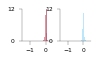

In [39]:
# Plot abundance histogram
plt.rcParams.update({'font.size': 6})

bins = np.linspace(-1.5,0.5,100)
plt.figure(figsize=(1.1,0.7))

plt.subplot(1,2,1)
u = np.histogram(np.log10(np.array(Y_no_pfs) / np.array(X_no_pfs)), bins=bins, density=True)
m = np.mean(np.log10(np.array(Y_no_pfs) / np.array(X_no_pfs)))
plt.axvline(m, color=[0.2, 0.25, 0.3], lw=0.5)
plt.fill_between(u[1][1:],u[0], step="pre", color=[[0.2, 0.25, 0.3]], lw=0, alpha=0.25)
plt.xlim([-1.5, 0.5])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

u = np.histogram(np.log10(np.array(Y_has_pfs) / np.array(X_has_pfs)), bins=bins, density=True)
m = np.mean(np.log10(np.array(Y_has_pfs) / np.array(X_has_pfs)))
plt.axvline(m, color=[241/255, 95/255, 121/255], lw=0.5)
plt.fill_between(u[1][1:],u[0], step="pre", color=[[241/255, 95/255, 121/255]], lw=0, alpha=0.5)
plt.xlim([-1.5, 0.5])
plt.ylim([0,12])
plt.yticks([0,12])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.25)
    ax.tick_params(width=0.25)

plt.gcf().subplots_adjust(bottom=0.25, right=1)

plt.subplot(1,2,2)
u = np.histogram(np.log10(np.array(Y_nt) / np.array(X_nt)), bins=bins, density=True)
plt.fill_between(u[1][1:],u[0], step="pre", color=[[188/255, 230/255, 250/255]], lw=0)

plt.xlim([-1.5, 0.5])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim([0,12])
plt.yticks([0,12])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.25)
    ax.tick_params(width=0.25)

plt.savefig('./generated_data_and_data/'+ortholog + ' Depletion Ratios With PFS.pdf')
plt.show()

In [40]:
# PFS Efficacy in prediction
pfs_eff = np.sum(np.array(Y_has_pfs) / np.array(X_has_pfs) < depletion_thresh) / len(Y_has_pfs)
off_target = np.sum(np.array(Y_nt) / np.array(X_nt) < depletion_thresh) / len(Y_nt)
eff = np.sum(np.array(Y) / np.array(X) < depletion_thresh) / len(Y)

print(pfs_eff, eff, off_target)

0.008299666256806604 0.008647978331103352 0.0044444444444444444


In [41]:
# Get coordinates and guide information on a per CDS basis
spacer_len = 30
counts = {}
guides = {}
for i in range(len(all_rep)):
    search = Bio.Seq.reverse_complement(all_rep[i][0])
    s = ''
    coords = (None,None)  
    for j,(name, seq) in enumerate(cds):
        # Find match
        idx = seq.find(search)
        if idx > 0:
            # If match, extract match sequence and coordinates
            s = seq[idx-6:idx+spacer_len+6]
            coords = (idx, (idx - flank) / (len(seq)-2*flank), 1)
            # Count number of guides mapping to the CDS j
            counts[j] = counts.get(j,0) + 1
            if not j in guides:
                guides[j] = []
            # Append all the guides matching to this CDS
            guides[j].append(search)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [42]:
# Get depletion information on a per CDS basis 
depletion_info = []
depletion_no_pam_info = []
depletion_nt_info = []
all_js = set()
spacer_len = 30
for i in range(len(all_rep)):
    search = Bio.Seq.reverse_complement(all_rep[i][0])
    # Get the normalized depletion (NT median divided off)
    d = all_rep[i][1]
    s = ''
    coords = (None,None)
    for j,(name, seq) in enumerate(cds):
        if not j in guides:
            continue
        rc = Bio.Seq.reverse_complement(seq)
        idx = seq.find(search)
        if idx >= 6:
            s = seq[idx-6:idx+spacer_len+6]
            coords = (idx, (idx - flank) / (len(seq)-2*flank), 1)
            break

    if all_rep[i][0] in nt_spacers:
        depletion_nt_info.append((j, coords, s, d))
        continue
    if s == '':
        continue
    if len(s) < spacer_len+12:
        print(s)
        continue
    # Cas13b-t2 specific conditions
    if s[5] != 'C':
        depletion_info.append((j, coords, s, d))
    else:        
        depletion_no_pam_info.append((j, coords, s, d))

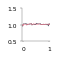

In [43]:
import itertools
delta = 0.025
# Create a coordinate line linspace
L = np.arange(-0.05,1.05+delta/2,delta)
V = []
V_no_pam = []
for i in range(len(L)-1):    
    l = L[i]
    u = L[i+1]
    kv = [(v[0],v[3]) for v in depletion_info if (not v[1][1] is None) and l <= v[1][1] and v[1][1] < u]
    # Groupby
    gb = {}
    for j,d in kv:
        if not j in gb:
            gb[j] = []
        gb[j].append(d)
    # Calculate mean across each cds
    mean_by_cds = list(map(lambda x: (x[0], np.mean(x[1])),gb.items()))
    # Take mean of means
    v = np.mean([m for j,m in mean_by_cds])
    V.append(v)
    
    kv = [(v[0],v[3]) for v in depletion_no_pam_info if (not v[1][1] is None) and l <= v[1][1] and v[1][1] < u]
    # Groupby
    gb = {}
    for j,d in kv:
        if not j in gb:
            gb[j] = []
        gb[j].append(d)
    # Calculate mean across each cds
    mean_by_cds = list(map(lambda x: (x[0], np.mean(x[1])),gb.items()))
    # Take mean of means
    v = np.mean([m for j,m in mean_by_cds])
    V_no_pam.append(v)

W = [v[3] for v in depletion_no_pam_info + depletion_info if not v[1][1] is None and l <= v[1][1] and v[1][1] < u]
div_factor = 1
   
plt.figure(figsize=(0.5,0.6))
plt.plot(L[:-1]+delta/2,np.array(V_no_pam),color=[0.2, 0.25, 0.3], lw=0.5)
plt.plot(L[:-1]+delta/2,np.array(V),color=[241/255, 95/255, 121/255], lw=0.5)
plt.ylim([0.5,1.5])
plt.yticks([0.5,1,1.5])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.25)
    ax.tick_params(width=0.25)
    
ax.tick_params(axis='x',direction='out', length=1.44, width=0.25)
ax.tick_params(axis='y',direction='out', length=1.80, width=0.25)

plt.xlim([-0.05,1.05])
    
plt.savefig('./generated_data_and_data/'+ortholog+' positional_preference.pdf')

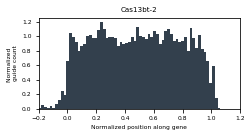

In [44]:
pos = [u[1][1] for u in depletion_info if not u[1][1] is None]

plt.figure(figsize=(4,2))
plt.hist(pos, 100, color=[0.2, 0.25, 0.3], density=True)
plt.xlabel('Normalized position along gene')
plt.ylabel('Normalized \nguide count')
plt.title(ortholog)
plt.xlim([-0.2, 1.2])
plt.gcf().subplots_adjust(bottom=0.25, left=0.2)
plt.savefig('./generated_data_and_data/'+ortholog + ' Gene Position Distribution.pdf')
plt.show()

In [45]:
depletion_info = []
all_depletion_info = []
all_js = set()
spacer_len = 30
for i in range(len(all_rep)):
    search = Bio.Seq.reverse_complement(all_rep[i][0])
    d = all_rep[i][1] 
    s = ''
    coords = (None,None)
    for j,(name, seq) in enumerate(cds):
        if not j in guides:
            continue
        rc = Bio.Seq.reverse_complement(seq)
        idx = seq.find(search)
        if idx >= 6:
            s = seq[idx-6:idx+spacer_len+6]
            coords = (idx, (idx - flank) / (len(seq)-2*flank), 1)
            break

    if all_rep[i][0] in nt_spacers:
        depletion_nt_info.append((j, coords, s, d))
        continue
    if s == '':
        continue
    if len(s) < spacer_len+12:
        print(s)
        continue
    if d < depletion_thresh:
        depletion_info.append((j, coords, s, d))
    all_depletion_info.append((j, coords, s, d))
print(len(depletion_info))
print(len(all_depletion_info))

265
30643


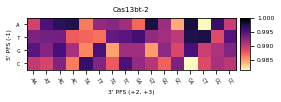

In [46]:
# Multi positional preferences 
bases = ['A', 'T', 'G', 'C']
p1 = 5
p2 = 37
p3 = 38
tokens = {(a,b,c) : 0 for a in bases for b in bases for c in bases}
tokens_all = {(a,b,c) : 0 for a in bases for b in bases for c in bases}
for i in range(len(depletion_info)):
    try:
        token = (str(depletion_info[i][2][p1]), str(depletion_info[i][2][p2]), str(depletion_info[i][2][p3]))
        tokens[token] += 1
    except:
        pass
for i in range(len(all_depletion_info)):
    try:
        token = (str(all_depletion_info[i][2][p1]), str(all_depletion_info[i][2][p2]), str(all_depletion_info[i][2][p3]))
        tokens_all[token] += 1
    except:
        pass
    
token_depletion = {u : 1-tokens[u] / (tokens_all[u]+0.001) for u in tokens.keys()}
dual_bases = [(a,b) for a in bases for b in bases]
dual_bases_labels = [a+b for a,b in dual_bases]

Z = np.zeros((4,16))
for i,a in enumerate(bases):
    for j,(b,c) in enumerate(dual_bases):
        token = (a,b,c)
        depletion = token_depletion[token]
        Z[i,j] = depletion
plt.figure(figsize=(4,1.75))
cm = plt.cm.get_cmap('magma_r')
ax = plt.gca()
im = plt.imshow(Z,cmap=cm, vmax=1)
ax.set_xticks(np.arange(len(dual_bases_labels)))
ax.set_yticks(np.arange(len(bases)))
# ... and label them with the respective list entries
ax.set_xticklabels(dual_bases_labels, rotation=-60, fontdict={'fontfamily' : 'Andale Mono'})
ax.set_yticklabels(bases,rotation=0, fontdict={'fontfamily' : 'Andale Mono'})
plt.xlabel('3\' PFS (+2, +3)')
plt.ylabel('5\' PFS (-1)')
plt.title(ortholog)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

plt.savefig('./generated_data_and_data/'+ortholog + ' pfs map.pdf')
plt.show()